In [20]:
import numpy as np
import pickle, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF

pd.set_option('display.max_columns', 35)

In [21]:
path = '../input/house-prices-advanced-regression-techniques/train.csv'
hspr = pd.read_csv(path) # titanic_fullsample
hspr['sample']='train'
hspr.reset_index(inplace=True, drop=True)
print(hspr.head())
print(hspr.shape)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  ...  PavedDrive  WoodDeckSF  OpenPorchSF  \
0       Norm     1Fam     2Story  ...           Y 

In [22]:
hspr0 = hspr.copy()
cols_tokeep = ['SalePrice', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond',
               'BsmtFinSF1', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 
               'KitchenQual', 'GarageArea', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr',
               'ExterQual', 'LotFrontage', 'sample']
hspr = hspr[cols_tokeep]
hspr.dropna(subset=hspr.columns.drop('SalePrice'), inplace=True)
hspr.info()
# there are no missing values.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalePrice     1201 non-null   int64  
 1   LotArea       1201 non-null   int64  
 2   OverallQual   1201 non-null   int64  
 3   OverallCond   1201 non-null   int64  
 4   YearBuilt     1201 non-null   int64  
 5   ExterCond     1201 non-null   object 
 6   BsmtFinSF1    1201 non-null   int64  
 7   TotalBsmtSF   1201 non-null   int64  
 8   HeatingQC     1201 non-null   object 
 9   1stFlrSF      1201 non-null   int64  
 10  2ndFlrSF      1201 non-null   int64  
 11  GrLivArea     1201 non-null   int64  
 12  FullBath      1201 non-null   int64  
 13  HalfBath      1201 non-null   int64  
 14  KitchenQual   1201 non-null   object 
 15  GarageArea    1201 non-null   int64  
 16  GarageCars    1201 non-null   int64  
 17  TotRmsAbvGrd  1201 non-null   int64  
 18  BedroomAbvGr  1201 non-null 

In [76]:
hspr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SalePrice,1201.0,180770.480433,83389.519866,34900.000000,127500.000000,159500.000000,213500.000000,755000.000000
LotArea,1201.0,9.080177,0.495587,7.170888,8.912069,9.133783,9.328123,12.279537
OverallQual,1201.0,6.122398,1.419216,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,1201.0,5.562032,1.094543,2.000000,5.000000,5.000000,6.000000,9.000000
ExterCond,1201.0,3.075770,0.348933,1.000000,3.000000,3.000000,3.000000,5.000000
BsmtFinSF1,1201.0,427.063281,464.589556,0.000000,0.000000,352.000000,690.000000,5644.000000
TotalBsmtSF,1201.0,1059.384679,448.307125,0.000000,784.000000,990.000000,1309.000000,6110.000000
HeatingQC,1201.0,4.172356,0.955389,1.000000,3.000000,5.000000,5.000000,5.000000
1stFlrSF,1201.0,1158.437968,386.257235,334.000000,876.000000,1082.000000,1383.000000,4692.000000
2ndFlrSF,1201.0,346.073272,435.143451,0.000000,0.000000,0.000000,728.000000,2065.000000


In [23]:
ord_cols = ['ExterCond', 'HeatingQC', 'KitchenQual', 'ExterQual']
hspr[ord_cols] = hspr[ord_cols].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
#print(hspr.BsmtCond.value_counts())

# it makes sense to replace YearBuilt with Age
hspr['Age']=2010-hspr.YearBuilt
hspr.drop(columns=['YearBuilt'], inplace=True)

# transform LotArea
hspr['LotArea']=np.log1p(hspr.LotArea)

In [24]:
# correlation analysis

corr_mat = hspr.corr()
print(corr_mat)

              SalePrice   LotArea  OverallQual  OverallCond  ExterCond  \
SalePrice      1.000000  0.414051     0.802287    -0.112568   0.009087   
LotArea        0.414051  1.000000     0.239960    -0.037224   0.007803   
OverallQual    0.802287  0.239960     1.000000    -0.127473   0.025009   
OverallCond   -0.112568 -0.037224    -0.127473     1.000000   0.392434   
ExterCond      0.009087  0.007803     0.025009     0.392434   1.000000   
BsmtFinSF1     0.403195  0.228447     0.268529    -0.049983   0.046986   
TotalBsmtSF    0.626977  0.376443     0.570354    -0.183888  -0.006068   
HeatingQC      0.450755  0.098592     0.496387    -0.001865   0.055783   
1stFlrSF       0.620159  0.455206     0.521423    -0.166526  -0.023866   
2ndFlrSF       0.308957  0.096136     0.281096     0.014451   0.021621   
GrLivArea      0.703557  0.412399     0.608072    -0.106823  -0.002772   
FullBath       0.566800  0.191615     0.564011    -0.217805  -0.015590   
HalfBath       0.284770  0.049922     

In [30]:
# preprocessing
#hspr.head()
X = hspr[hspr['sample']=='train'].copy()
X.drop(columns=['sample', 'SalePrice'], inplace=True)
y = hspr.SalePrice[hspr['sample']=='train'].copy()

s = MinMaxScaler()
X_df = pd.DataFrame(s.fit_transform(X), columns=X.columns)

In [31]:
X_df

,LotArea,OverallQual,OverallCond,ExterCond,BsmtFinSF1,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,KitchenQual,GarageArea,GarageCars,TotRmsAbvGrd,BedroomAbvGr,ExterQual,LotFrontage,Age
0,0.366271,0.666667,0.428571,0.50,0.125089,0.140098,1.00,0.119780,0.413559,0.259231,0.666667,0.5,0.666667,0.386460,0.50,0.500000,0.375,0.666667,0.150685,0.050725
1,0.391245,0.555556,0.857143,0.50,0.173281,0.206547,1.00,0.212942,0.000000,0.174830,0.666667,0.0,0.333333,0.324401,0.50,0.333333,0.375,0.333333,0.202055,0.246377
2,0.422289,0.666667,0.428571,0.50,0.086109,0.150573,1.00,0.134465,0.419370,0.273549,0.666667,0.5,0.666667,0.428773,0.50,0.333333,0.375,0.666667,0.160959,0.065217
3,0.390223,0.666667,0.428571,0.50,0.038271,0.123732,0.75,0.143873,0.366102,0.260550,0.333333,0.0,0.666667,0.452750,0.75,0.416667,0.375,0.333333,0.133562,0.688406
4,0.468694,0.777778,0.428571,0.50,0.116052,0.187398,1.00,0.186095,0.509927,0.351168,0.666667,0.5,0.666667,0.589563,0.75,0.583333,0.500,0.666667,0.215753,0.072464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,0.353519,0.555556,0.428571,0.50,0.000000,0.155974,1.00,0.142038,0.336077,0.247362,0.666667,0.5,0.333333,0.324401,0.50,0.416667,0.375,0.333333,0.140411,0.079710
1197,0.453205,0.555556,0.571429,0.50,0.139972,0.252373,0.50,0.399036,0.000000,0.327619,0.666667,0.0,0.333333,0.352609,0.50,0.416667,0.375,0.333333,0.219178,0.231884
1198,0.379525,0.666667,1.000000,0.75,0.048724,0.188543,1.00,0.195961,0.557869,0.377920,0.666667,0.0,0.666667,0.177715,0.25,0.583333,0.500,1.000000,0.154110,0.500000
1199,0.393616,0.444444,0.571429,0.50,0.008682,0.176432,0.75,0.170721,0.000000,0.140166,0.333333,0.0,0.666667,0.169252,0.25,0.250000,0.250,0.333333,0.160959,0.434783


In [33]:
# PCA #

data = X_df.copy()

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 10):
    
    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data)
    
    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))
    
    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n, 
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))
    
pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.400813
2,PCA(n_components=2),0.564632
3,PCA(n_components=3),0.648055
4,PCA(n_components=4),0.729695
5,PCA(n_components=5),0.786633
6,PCA(n_components=6),0.831596
7,PCA(n_components=7),0.864458
8,PCA(n_components=8),0.892509
9,PCA(n_components=9),0.913923


In [34]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,1stFlrSF,2ndFlrSF,Age,BedroomAbvGr,BsmtFinSF1,ExterCond,ExterQual,FullBath,GarageArea,GarageCars,GrLivArea,HalfBath,HeatingQC,KitchenQual,LotArea,LotFrontage,OverallCond,OverallQual,TotRmsAbvGrd,TotalBsmtSF
n,,,,,,,,,,,,,,,,,,,,
1,0.026086,0.046196,0.099512,0.010103,0.012701,0.000855,0.093841,0.073548,0.065118,0.085465,0.039000,0.058101,0.089142,0.106092,0.015649,0.014109,0.021665,0.077714,0.041576,0.023527
2,0.029008,0.113899,0.089138,0.031292,0.014928,0.000664,0.070605,0.047828,0.046758,0.056630,0.044704,0.126981,0.079336,0.080856,0.010938,0.008693,0.018761,0.047449,0.056234,0.025297
3,0.035852,0.074939,0.065927,0.035924,0.014548,0.005510,0.052678,0.056575,0.058047,0.069777,0.043583,0.115291,0.109916,0.067371,0.023258,0.018644,0.032724,0.034344,0.059707,0.025384
4,0.030823,0.073860,0.086098,0.037366,0.013500,0.012160,0.042098,0.057175,0.048496,0.060962,0.043444,0.120084,0.107417,0.061344,0.023645,0.017653,0.053234,0.029959,0.060764,0.019919
5,0.028477,0.068683,0.085555,0.037115,0.016959,0.017200,0.037109,0.071679,0.054513,0.064683,0.035053,0.107715,0.098396,0.066623,0.024253,0.017823,0.068364,0.027992,0.052539,0.019268
6,0.024572,0.060269,0.075841,0.034181,0.015120,0.014875,0.047487,0.068966,0.063122,0.076307,0.030657,0.095389,0.111003,0.083279,0.027399,0.019869,0.058985,0.030276,0.045694,0.016708
7,0.033739,0.061044,0.069203,0.034042,0.020846,0.018023,0.042121,0.068864,0.059352,0.077101,0.032558,0.086418,0.098606,0.069488,0.037657,0.028477,0.062431,0.027728,0.048448,0.023854
8,0.034519,0.061283,0.075282,0.035192,0.023424,0.024127,0.042452,0.070160,0.055773,0.072751,0.029130,0.079964,0.088990,0.069112,0.037473,0.029406,0.075308,0.027206,0.043952,0.024495
9,0.032370,0.057216,0.072702,0.035978,0.021736,0.023290,0.061855,0.067439,0.051952,0.067096,0.027686,0.074024,0.083159,0.082657,0.037740,0.029895,0.071604,0.035682,0.041587,0.024333


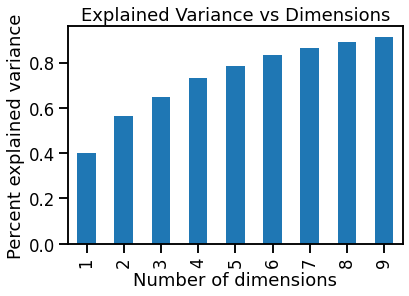

In [35]:
sns.set_context('talk')
ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

In [74]:
PCAmod = PCA(n_components=6)
PCAmod.fit(data)
xhat = PCAmod.predict(data)

AttributeError: 'PCA' object has no attribute 'predict'

In [36]:
### Kernel PCA ###
# Custom scorer--use negative rmse of inverse transform
def scorer(pcamodel, X, y=None):

    try:
        X_val = X.values
    except:
        X_val = X
        
    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)
    
    # The error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())
    
    # Larger values are better for scorers, so take negative value
    return -1.0 * mse

In [73]:
# The grid search parameters
param_grid = {'gamma':[0.1, 0.5, 1.0, 2, 5],
              'n_components': [5, 6, 7, 8, 9, 10, 11, 12]}

# The grid search
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(data)

kernelPCA.best_estimator_
temp = kernelPCA.best_score_

(KernelPCA(fit_inverse_transform=True, gamma=2, kernel='rbf', n_components=11),
 -1.3335517615854319e-31)

In [44]:
data.shape

(1201, 20)

In [45]:
### Autoencoder ###

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

ENCODING_DIM = 10
HIDDEN_DIM = 5
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(20,)) 
encoder_hidden = Dense(HIDDEN_DIM, activation="sigmoid")(inputs)
encoded = Dense(ENCODING_DIM, activation="relu")(encoder_hidden)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(20, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

In [49]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

#loss='binary_crossentropy',metrics=['accuracy']
full_model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [53]:
history = full_model.fit(data, data, epochs=10, batch_size=50)
history.history


Epoch 1/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5805
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5803
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5800
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5798
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5795
Epoch 6/10
25/25 [==============================] - 0s 2ms/step - loss: 0.5792
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5790
Epoch 8/10
25/25 [==============================] - 0s 2ms/step - loss: 0.5788
Epoch 9/10
25/25 [==============================] - 0s 2ms/step - loss: 0.5785
Epoch 10/10
25/25 [==============================] - 0s 2ms/step - loss: 0.5783


{'loss': [0.5805333852767944,
  0.58030104637146,
  0.5800284147262573,
  0.5797609686851501,
  0.5794517397880554,
  0.5792188048362732,
  0.5789856910705566,
  0.5787530541419983,
  0.5785292983055115,
  0.5783006548881531]}

In [65]:
encoder_prd = encoder_model.predict(data)
encoder_prd.shape

(1201, 10)

In [55]:
# Generate reconstructed images
decoded_prd = full_model.predict(data)
mse_reconstruction(encoder_prd, decoded_prd)


NameError: name 'mse_reconstruction' is not defined

In [72]:
np.sum(np.sum(np.power(decoded_prd - data, 2))) / (decoded_prd.shape[0]*decoded_prd.shape[1])

0.02485380808352352